# Performing photometry (automated)

In [1]:
###PURPOSE: make an astropy table with all of the correct and relevant file names for each source
### we want to run photometry on

import sys

#import statements
from astropy.io import ascii
import pandas as pd
from astropy.table import join
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
from photutils.aperture import CircularAnnulus, CircularAperture
from astropy import wcs
from photutils.aperture import SkyCircularAnnulus
from photutils.aperture import aperture_photometry
import numpy as np
import matplotlib.pyplot as plt
import aplpy
from itertools import cycle
from photutils.aperture import ApertureStats
from astropy.stats import median_absolute_deviation
from astropy.table import vstack
from astropy.table import Column
from astropy.table import join

#function to help us with plotting later on 
def fix_aplpy_fits(aplpy_obj, dropaxis=2):
    """This removes the degenerated dimensions in APLpy 2.X...
    The input must be the object returned by aplpy.FITSFigure().
    `dropaxis` is the index where to start dropping the axis (by default it assumes the 3rd,4th place).
    """
    temp_wcs = aplpy_obj._wcs.dropaxis(dropaxis)
    temp_wcs = temp_wcs.dropaxis(dropaxis)
    aplpy_obj._wcs = temp_wcs
    
scale=0.00055556*u.degree
scalearcsec=scale.to('arcsec')
length=scalearcsec.value*(19e6*u.AU)
lengthpc=length.to(u.pc)
lengtharcsec=(lengthpc/(19.3e6*u.pc))*u.arcsec
distance=19e6*u.Mpc
pclabel=(distance.value*u.AU).to(u.pc)

#read in photometry sources Google Sheet
data = ascii.read('/users/adignan/photometry_sources.csv', format='csv')

#read in Sean's catalog
df = ascii.read('/lustre/cv/students/adignan/Linden2020_table5.csv', format='csv')

minitbl=df[['Source ID','RA_J2000','Decl_J2000']]
tbl=join(data,minitbl,'Source ID')

path='/lustre/cv/students/adignan/data/'

results1=[]
medians=[]
means=[]
mads=[]
stds=[]
names1=[]
errs1=[]
snrs=[]
beams=[]
rins=[]
routs=[]
unscaledmad1=[]
scaledmad1=[]

# tbl=tbl[tbl['Source ID']=='NGC2798']

for row in tbl:
    print('Working on ' + str(row['Source ID']))
    #read in relevant data files
    file3=fits.open(str(row['3 GHz file']))[0]
    file15=fits.open(str(row['15 GHz file']))[0]
    file33=fits.open(str(row['33 GHz file']))[0]
    file90 = fits.open(str(row['90 GHz file']))[0]

    data3=file3.data[0,0,:,:]
    data15=file15.data[0,0,:,:]
    data33=file33.data[0,0,:,:]
    data90=file90.data[0,:,:]

    datas=[data3,data15,data33,data90]

    wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
    wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
    wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
    wcs90=wcs.WCS(file90).dropaxis(2)

    wcss=[wcs3,wcs15,wcs33,wcs90]

    ras=[]
    decs=[]

    #pull out ra and dec info
    r=(row['RA_J2000'])
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
    d=(row['Decl_J2000'])
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

    positions=[]

    for r, d in zip(ras,decs):
        position=SkyCoord(ra=r,dec=d)
        positions.append(position)
        
    fwhm = row['Beam']*u.arcsec
    rin = 1.5*fwhm 
    rout = rin + fwhm

    #creating lists of the apertures and annuli (defined in sky coordinates)
    skyapertures=[]
    skyannuli=[]

    for p in positions:
        skyaperture = SkyCircularAperture(p, r=fwhm)
        skyannulus = SkyCircularAnnulus(p, rin, rout)
        skyapertures.append(skyaperture)
        skyannuli.append(skyannulus)
        
    factor=((scalearcsec.value)**2)/((np.pi/(4*np.log(2))) *(fwhm.value)**2)

    omega= (np.pi / (4*np.log(2)) ) * ((fwhm.value)**2)
    n= ((np.pi) * ((fwhm.value)**2)) / (omega)

    for ap, ann in zip(skyapertures,skyannuli):
        for d, w in zip((datas),wcss):
            phot=aperture_photometry(data=d,apertures=ap,wcs=w)
            aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
            phot['pbcorr_flux_density']=(phot['aperture_sum']*factor)*1000
            phot['pbcorr_aperture_sum']=(phot['aperture_sum'])*1000
            results1.append(phot)
            medians.append(aperstats.median*1000)
            means.append(aperstats.mean*1000)
            mads.append(aperstats.mad_std*1000)
            stds.append(aperstats.std*1000)
            names1.append(row['Source ID'])
            beams.append(row['Beam'])
            rins.append((1.5*row['Beam']))
            routs.append(((1.5*row['Beam'])+row['Beam']))
            madvalue = median_absolute_deviation(d,ignore_nan=True)
            unscaledmad1.append(madvalue*1000)
            scaledmad1.append(madvalue*1000)

    table_stacked = vstack(results1)
    
    medianscol=Column(medians,name='median',unit='mJy')
    meanscol=Column(means,name='mean',unit='mJy')
    madscol=Column(mads,name='mad',unit='mJy')
    rmscol=Column(stds,name='std',unit='mJy')
    namecol1=Column(names1,name='source ID')
    beamcol=Column(beams,name='radius',unit='arcsec')
    rincol=Column(rins,name='radius_in',unit='arcsec')
    routcol=Column(routs,name='radius_out',unit='arcsec')
    unscaledmadcol1=Column(unscaledmad1,name='unscaled mad entire image',unit='mJy')
    scaledmadcol1=Column(scaledmad1,name='scaled mad entire image',unit='mJy')

    table_stacked.add_columns([medianscol,meanscol,rmscol,madscol,unscaledmadcol1,scaledmadcol1])

    freqs = cycle(['3','15','33','90'])
    freqcol=Column(data=[next(freqs) for freq in range(len(table_stacked))],name='freq')
    table_stacked.add_column(freqcol,index=1)

    table_stacked.add_column(namecol1,index=0)

    table_stacked.remove_column('id')
    table_stacked.remove_column('aperture_sum')


    print('Just finished ' + str(row['Source ID']) + '! :)')
    

results=[]
names=[]
errs=[]
unscaledmad=[]
scaledmad=[]

#repeat process but for non pb corr images
for row in tbl:
    print('Working on ' + str(row['Source ID']))
    #read in relevant data files
    file3=fits.open(str(row['non pb corr 3 GHz file']))[0]
    file15=fits.open(str(row['non pb corr 15 GHz file']))[0]
    file33=fits.open(str(row['non pb corr 33 GHz file']))[0]
    file90 = fits.open(str(row['90 GHz file']))[0]

    data3=file3.data[0,0,:,:]
    data15=file15.data[0,0,:,:]
    data33=file33.data[0,0,:,:]
    data90=file90.data[0,:,:]

    datas=[data3,data15,data33,data90]

    wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
    wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
    wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
    wcs90=wcs.WCS(file90).dropaxis(2)

    wcss=[wcs3,wcs15,wcs33,wcs90]

    ras=[]
    decs=[]

    #pull out ra and dec info
    r=(row['RA_J2000'])
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
    d=(row['Decl_J2000'])
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

    positions=[]

    for r, d in zip(ras,decs):
        position=SkyCoord(ra=r,dec=d)
        positions.append(position)

    fwhm = row['Beam']*u.arcsec
    rin = 1.5*fwhm 
    rout = rin + fwhm

    #creating lists of the apertures and annuli (defined in sky coordinates)
    skyapertures=[]
    skyannuli=[]

    for p in positions:
        skyaperture = SkyCircularAperture(p, r=fwhm)
        skyannulus = SkyCircularAnnulus(p, rin, rout)
        skyapertures.append(skyaperture)
        skyannuli.append(skyannulus)

    factor=((scalearcsec.value)**2)/((np.pi/(4*np.log(2))) *(fwhm.value)**2)

    omega= (np.pi / (4*np.log(2)) ) * ((fwhm.value)**2)
    n= ((np.pi) * ((fwhm.value)**2)) / (omega)

    for ap, ann in zip(skyapertures,skyannuli):
        for d, w in zip((datas),wcss):
            phot=aperture_photometry(data=d,apertures=ap,wcs=w)
            aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
            phot['nonpbcorr_flux_density']=(phot['aperture_sum']*factor)*1000
            phot['nonpbcorr_aperture_sum']=(phot['aperture_sum'])*1000
            results.append(phot)
            names.append(row['Source ID'])
            madvalue = median_absolute_deviation(d,ignore_nan=True)
            unscaledmad.append(madvalue*1000)
            scaledmad.append(madvalue*1000)

    table_stacked_nonpbcorr = vstack(results)
    
    unscaledmadcol=Column(unscaledmad,name='non pb corr unscaled mad entire image',unit='mJy')
    scaledmadcol=Column(scaledmad,name='non pb corr scaled mad entire image',unit='mJy')

    table_stacked_nonpbcorr.add_columns([unscaledmadcol,scaledmadcol])
    
    freqs = cycle(['3','15','33','90'])
    freqcol=Column(data=[next(freqs) for freq in range(len(table_stacked_nonpbcorr))],name='freq')
    table_stacked_nonpbcorr.add_column(freqcol,index=1)

    namecol=Column(names,name='source ID')
    table_stacked_nonpbcorr.add_column(namecol,index=0)

    table_stacked_nonpbcorr.remove_column('id')
    table_stacked_nonpbcorr.remove_column('aperture_sum')


    print('Just finished ' + str(row['Source ID']) + '! :)')
    
ravals=[]
decvals=[]

for row in table_stacked:
    x1=(row['sky_center'].ra.degree)
    y1=(row['sky_center'].dec.degree)
    ravals.append(x1)
    decvals.append(y1)
    
racol=Column(data=ravals,unit='degree',name='RA')
deccol=Column(data=decvals,unit='degree',name='Dec')
table_stacked.add_columns([racol,deccol])


Working on NGC0337a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0337a! :)
Working on NGC0337b
Just finished NGC0337b! :)
Working on NGC0337c
Just finished NGC0337c! :)
Working on NGC0337d


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 fro

Just finished NGC0337d! :)
Working on NGC0628


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0628! :)
Working on NGC0628Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0628Enuc.1! :)
Working on NGC0628Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0628Enuc.2! :)
Working on NGC0628Enuc.3


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0628Enuc.3! :)
Working on NGC0628Enuc.4


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0628Enuc.4! :)
Working on NGC0925


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC0925! :)
Working on NGC2798


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC2798! :)
Working on NGC2841


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC2841! :)
Working on NGC3049


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3049! :)
Working on NGC3184


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3184! :)
Working on NGC3190


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3190! :)
Working on NGC3198


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3198! :)
Working on NGC3351a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3351a! :)
Working on NGC3351b
Just finished NGC3351b! :)
Working on NGC3521


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3521! :)
Working on NGC3521Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3521Enuc.1! :)
Working on NGC3521Enuc.3


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3521Enuc.3! :)
Working on NGC3627


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3627! :)
Working on NGC3627Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3627Enuc.1! :)
Working on NGC3627Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3627Enuc.2! :)
Working on NGC3773


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3773! :)
Working on NGC3938Enuc.2a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3938Enuc.2a! :)
Working on NGC3938Enuc.2b
Just finished NGC3938Enuc.2b! :)
Working on NGC3938a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC3938a! :)
Working on NGC3938b
Just finished NGC3938b! :)
Working on NGC4254a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4254a! :)
Working on NGC4254b
Just finished NGC4254b! :)
Working on NGC4254c


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4254c! :)
Working on NGC4254d
Just finished NGC4254d! :)
Working on NGC4254e


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4254e! :)
Working on NGC4254f
Just finished NGC4254f! :)
Working on NGC4321Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4321Enuc.1! :)
Working on NGC4321Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4321Enuc.2! :)
Working on NGC4321Enuc.2a
Just finished NGC4321Enuc.2a! :)
Working on NGC4321Enuc.2b


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4321Enuc.2b! :)
Working on NGC4321a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4321a! :)
Working on NGC4321b
Just finished NGC4321b! :)
Working on NGC4569


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4569! :)
Working on NGC4579


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4579! :)
Working on NGC4594a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4594a! :)
Working on NGC4725a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4725a! :)
Working on NGC6946Enuc.2a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.2a! :)
Working on NGC6946Enuc.2b
Just finished NGC6946Enuc.2b! :)
Working on NGC6946Enuc.3a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.3a! :)
Working on NGC6946Enuc.3b
Just finished NGC6946Enuc.3b! :)
Working on NGC6946Enuc.4a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.4a! :)
Working on NGC6946Enuc.4b
Just finished NGC6946Enuc.4b! :)
Working on NGC6946Enuc.4c


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.4c! :)
Working on NGC6946Enuc.5a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.5a! :)
Working on NGC6946Enuc.5b
Just finished NGC6946Enuc.5b! :)
Working on NGC6946Enuc.6a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.6a! :)
Working on NGC6946Enuc.6b
Just finished NGC6946Enuc.6b! :)
Working on NGC6946Enuc.7


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.7! :)
Working on NGC6946Enuc.8


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.8! :)
Working on NGC6946Enuc.9
Just finished NGC6946Enuc.9! :)
Working on NGC6946a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946a! :)
Working on NGC6946b
Just finished NGC6946b! :)
Working on NGC6946c


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946c! :)
Working on NGC7331


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC7331! :)
Working on NGC0337a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


00h59m50.018s
-07d34m33.9s
Just finished NGC0337a! :)
Working on NGC0337b
00h59m50.683s
-07d34m57.6s
Just finished NGC0337b! :)
Working on NGC0337c
00h59m51.995s
-07d34m54.9s
Just finished NGC0337c! :)
Working on NGC0337d
00h59m52.156s
-07d34m38.2s
Just finished NGC0337d! :)
Working on NGC0628


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 fro

01h36m41.7s
+15d46m59s
Just finished NGC0628! :)
Working on NGC0628Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


01h36m45.266s
+15d47m48.3s
Just finished NGC0628Enuc.1! :)
Working on NGC0628Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


01h36m37.645s
+15d45m07.2s
Just finished NGC0628Enuc.2! :)
Working on NGC0628Enuc.3


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


01h36m38.779s
+15d44m23.2s
Just finished NGC0628Enuc.3! :)
Working on NGC0628Enuc.4


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


01h36m35.718s
+15d50m07.25s
Just finished NGC0628Enuc.4! :)
Working on NGC0925


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


02h27m17s
+33d34m43s
Just finished NGC0925! :)
Working on NGC2798


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


09h17m22.854s
+42d00m00.4s
Just finished NGC2798! :)
Working on NGC2841


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


09h22m02.668s
+50d58m35.7s
Just finished NGC2841! :)
Working on NGC3049


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


09h54m49.559s
+09d16m16.1s
Just finished NGC3049! :)
Working on NGC3184


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


10h18m16.94s
+41d25m27s
Just finished NGC3184! :)
Working on NGC3190


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


10h18m05.643s
+21d49m55.9s
Just finished NGC3190! :)
Working on NGC3198


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


10h19m54.986s
+45d32m59.3s
Just finished NGC3198! :)
Working on NGC3351a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


10h43m57.677s
+11d42m08s
Just finished NGC3351a! :)
Working on NGC3351b
10h43m57.8s
+11d42m18.5s
Just finished NGC3351b! :)
Working on NGC3521


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h05m48.9s
-00d02m06s
Just finished NGC3521! :)
Working on NGC3521Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h05m46.3s
-00d04m08.992s
Just finished NGC3521Enuc.1! :)
Working on NGC3521Enuc.3


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h05m47.6s
+00d00m33.004s
Just finished NGC3521Enuc.3! :)
Working on NGC3627


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h20m15s
+12d59m29.4s
Just finished NGC3627! :)
Working on NGC3627Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h20m16.323s
+12d57m49.2s
Just finished NGC3627Enuc.1! :)
Working on NGC3627Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h20m16.464s
+12d58m43.4s
Just finished NGC3627Enuc.2! :)
Working on NGC3773


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h38m13.02s
+12d06m43.8s
Just finished NGC3773! :)
Working on NGC3938Enuc.2a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h53m00.056s
+44d08m00s
Just finished NGC3938Enuc.2a! :)
Working on NGC3938Enuc.2b
11h53m00.195s
+44d07m48.3s
Just finished NGC3938Enuc.2b! :)
Working on NGC3938a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


11h52m49.5s
+44d07m14s
Just finished NGC3938a! :)
Working on NGC3938b
11h52m48.191s
+44d07m05.9s
Just finished NGC3938b! :)
Working on NGC4254a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m48.677s
+14d24m42.5s
Just finished NGC4254a! :)
Working on NGC4254b


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m49.668s
+14d24m59s
Just finished NGC4254b! :)
Working on NGC4254c


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m50.102s
+14d25m11.6s
Just finished NGC4254c! :)
Working on NGC4254d


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m51.63s
+14d25m08.599s
Just finished NGC4254d! :)
Working on NGC4254e


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m51.899s
+14d24m49.699s
Just finished NGC4254e! :)
Working on NGC4254f


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h18m51.919s
+14d24m40.099s
Just finished NGC4254f! :)
Working on NGC4321Enuc.1


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h22m58.9s
+15d49m35.003s
Just finished NGC4321Enuc.1! :)
Working on NGC4321Enuc.2


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h22m50.652s
+15d50m27.2s
Just finished NGC4321Enuc.2! :)
Working on NGC4321Enuc.2a
12h22m48.844s
+15d50m12.8s
Just finished NGC4321Enuc.2a! :)
Working on NGC4321Enuc.2b
12h22m49.904s
+15d50m27.8s
Just finished NGC4321Enuc.2b! :)
Working on NGC4321a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 fro

12h22m54.651s
+15d49m19.8s
Just finished NGC4321a! :)
Working on NGC4321b
12h22m55.129s
+15d49m20.4s
Just finished NGC4321b! :)
Working on NGC4569
12h36m49.8s
+13d09m46.6s


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC4569! :)
Working on NGC4579


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h37m43.518s
+11d49m05.6s
Just finished NGC4579! :)
Working on NGC4594a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h39m59.42s
-11d37m23s
Just finished NGC4594a! :)
Working on NGC4725a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


12h50m26.556s
+25d30m03s
Just finished NGC4725a! :)
Working on NGC6946Enuc.2a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h35m23.572s
+60d09m48.899s
Just finished NGC6946Enuc.2a! :)
Working on NGC6946Enuc.2b
20h35m25.381s
+60d09m58.8s
Just finished NGC6946Enuc.2b! :)
Working on NGC6946Enuc.3a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h34m49.865s
+60d12m40.699s
Just finished NGC6946Enuc.3a! :)
Working on NGC6946Enuc.3b
20h34m52.24s
+60d12m43.7s
Just finished NGC6946Enuc.3b! :)
Working on NGC6946Enuc.4a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h34m19.842s
+60d10m06.6s
Just finished NGC6946Enuc.4a! :)
Working on NGC6946Enuc.4b
20h34m21.41s
+60d10m17.699s
Just finished NGC6946Enuc.4b! :)
Working on NGC6946Enuc.4c
20h34m22.738s
+60d10m34.197s
Just finished NGC6946Enuc.4c! :)
Working on NGC6946Enuc.5a


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 fro

20h34m37.155s
+60d05m10.099s
Just finished NGC6946Enuc.5a! :)
Working on NGC6946Enuc.5b
20h34m39.361s
+60d04m52.4s
Just finished NGC6946Enuc.5b! :)
Working on NGC6946Enuc.6a
20h35m06.08s
+60d10m58.5s


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946Enuc.6a! :)
Working on NGC6946Enuc.6b
20h35m06.965s
+60d10m46.5s
Just finished NGC6946Enuc.6b! :)
Working on NGC6946Enuc.7


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h35m12.974s
+60d08m50.55s
Just finished NGC6946Enuc.7! :)
Working on NGC6946Enuc.8


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h34m32.28s
+60d10m19.3s
Just finished NGC6946Enuc.8! :)
Working on NGC6946Enuc.9
20h35m11.086s
+60d08m57.45s
Just finished NGC6946Enuc.9! :)
Working on NGC6946a
20h34m51.295s
+60d09m39.2s


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


Just finished NGC6946a! :)
Working on NGC6946b
20h34m52.26s
+60d09m14.3s
Just finished NGC6946b! :)
Working on NGC6946c


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


20h34m52.742s
+60d09m30.5s
Just finished NGC6946c! :)
Working on NGC7331


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


22h37m04.1s
+34d24m56s
Just finished NGC7331! :)


In [2]:
# table_stacked.add_column(table_stacked_nonpbcorr['non pb corr scaled mad entire image'])
# table_stacked.add_column(table_stacked_nonpbcorr[''])
merged_table=join(table_stacked,table_stacked_nonpbcorr,keys=('source ID','freq'))
merged_table.remove_columns(['xcenter_2','ycenter_2','sky_center_2'])
merged_table

rationew=np.divide(merged_table['pbcorr_flux_density'],merged_table['nonpbcorr_flux_density'])
newratiocol=Column(data=rationew,name='pbcorr/nonpbcorr')
errorcol=Column(data=merged_table['scaled mad entire image']*np.sqrt(n)*merged_table['pbcorr_flux_density'],name='error')
merged_table.add_columns([newratiocol,errorcol])
merged_table

source ID,freq,xcenter_1,ycenter_1,sky_center_1,pbcorr_flux_density,pbcorr_aperture_sum,median,mean,std,mad,unscaled mad entire image,scaled mad entire image,RA,Dec,nonpbcorr_flux_density,nonpbcorr_aperture_sum,non pb corr unscaled mad entire image,non pb corr scaled mad entire image,pbcorr/nonpbcorr,error
,,pix,pix,"deg,deg",,,mJy,mJy,mJy,mJy,mJy,mJy,deg,deg,,,mJy,mJy,,mJy
str14,str2,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
NGC0337a,15,163.08660398624397,166.05182461915973,"14.958408333333331,-7.576083333333333",1.252183239140013,32.202869648747054,0.14866785204503685,0.23555952583344547,0.2720863038848723,0.06407481475254288,0.10690979252103716,0.10690979252103716,14.958408333333331,-7.576083333333333,1.238872722085565,31.86055805068079,0.04947710476699285,0.04947710476699285,1.0107440553150935,0.22290925440319578
NGC0337a,3,163.08660398624397,166.05182461915973,"14.958408333333331,-7.576083333333333",1.7205513778781547,44.24807010181282,0.1603786222403869,0.332031413071021,0.49764989970348195,0.11283610033899386,0.05721887282561511,0.05721887282561511,14.958408333333331,-7.576083333333333,1.7198174213412785,44.22919466414038,0.054272917623165995,0.054272917623165995,1.0004267642179736,0.1639266901700945
NGC0337a,33,163.08660398624397,166.05182461915973,"14.958408333333331,-7.576083333333333",0.6047965207377465,15.553780718794354,0.01699945096333977,0.018868610739188267,0.1879614409261915,0.10039917201028158,0.10189894237555563,0.10189894237555563,14.958408333333331,-7.576083333333333,0.5785259106271867,14.878169509076814,0.04196152804070152,0.04196152804070152,1.0454095652899618,0.10261756064955602
NGC0337a,90,163.08660398624397,166.05182461915973,"14.958408333333331,-7.576083333333333",0.5992092038186183,15.410089577746582,0.06498488801298663,0.05021175946647102,0.31259012442833134,0.31950084849466653,0.0,0.0,14.958408333333331,-7.576083333333333,0.5992092038186183,15.410089577746582,0.0,0.0,1.0,0.0
NGC0337b,15,158.1426866107587,154.20182190894883,"14.961179166666664,-7.582666666666666",2.5329128283966638,65.13987657310956,0.11702247138600796,0.15004789714653136,0.19362638633501125,0.1898032233480022,0.10690979252103716,0.10690979252103716,14.961179166666664,-7.582666666666666,2.4887357702700563,64.00375847166195,0.04947710476699285,0.04947710476699285,1.0177508028993427,0.450900229613326
NGC0337b,3,158.1426866107587,154.20182190894883,"14.961179166666664,-7.582666666666666",4.663467567533819,119.9321580854182,0.15097580035217106,0.22900654470052834,0.255385536899418,0.21838307171046994,0.05721887282561511,0.05721887282561511,14.961179166666664,-7.582666666666666,4.660044164639309,119.84411713923627,0.054272917623165995,0.054272917623165995,1.000734628851908,0.4443150102289699
NGC0337b,33,158.1426866107587,154.20182190894883,"14.961179166666664,-7.582666666666666",1.4756634929073624,37.95019580372856,0.015951794466673164,0.025891644598810274,0.13919911042862074,0.1349915229947803,0.10189894237555563,0.10189894237555563,14.961179166666664,-7.582666666666666,1.3398847825758784,34.45832338984549,0.04196152804070152,0.04196152804070152,1.1013361089678582,0.25038005806819114
NGC0337b,90,158.1426866107587,154.20182190894883,"14.961179166666664,-7.582666666666666",1.5281484758635486,39.29997194816536,0.047167537559289485,0.04127325893666917,0.3143429725144839,0.32175695821140926,0.0,0.0,14.961179166666664,-7.582666666666666,1.5281484758635486,39.29997194816536,0.0,0.0,1.0,0.0


Working on NGC0337a
INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


/lustre/cv/students/adignan/data/NGC0337/ngc0337_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits
INFO: Auto-setting vmin to -3.309e-01 [aplpy.core]
INFO: Auto-setting vmax to  1.233e+00 [aplpy.core]


KeyError: 'RA'

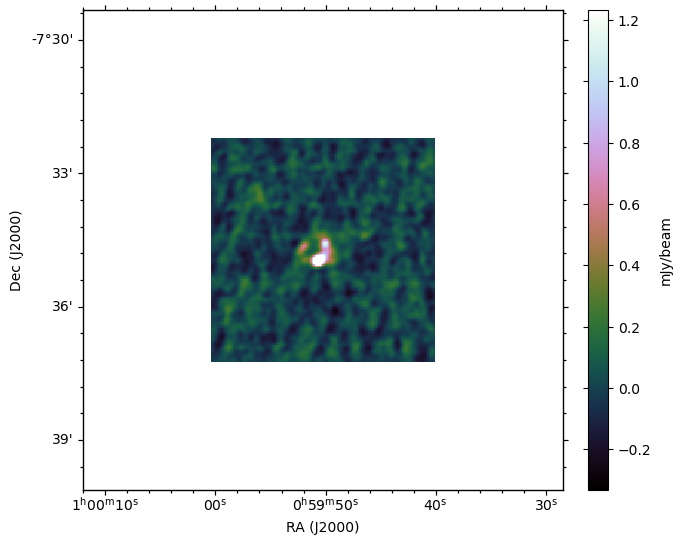

In [5]:
import matplotlib
import matplotlib.pyplot as plt

for i in range(1):
    for row in tbl[:1]:
        print('Working on ' + str(row['Source ID']))
        #set up the subplots
        fig = plt.figure(figsize=(15,15))
        
        #set width and height parameters for recentering
        w=0.075
        h=0.075
        #3 GHz image
        #plot the fits file
        f1 = aplpy.FITSFigure(data=str(row['3 GHz file'])[:-5]+'_copy.fits', figure=fig, subplot=[0.1,0.5,0.35,0.35])
        print(str(row['3 GHz file']))
        fix_aplpy_fits(f1)
        #pick out a colormap to use
        f1.show_colorscale(cmap='cubehelix')
        f1.add_colorbar()
        f1.colorbar.set_pad(0.25)
        #recenter based on pixel coordinates of aperture
        f1.colorbar.set_axis_label_text('mJy/beam')
        f1.recenter(table_stacked['RA'][i:i+1],table_stacked['Dec'][i:i+1],width=w, height=h)
        #plot the aperture and annulus
        f1.show_regions('/users/adignan/regfiles/'+str(row['Source ID'])+'_3GHz.reg')
        f1.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f1.scalebar.set(color='white',linewidth=3) 
        f1.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f1.axis_labels.hide()
        f1.set_title('3 GHz',fontsize=15)

        #15 GHz image
        f2 = aplpy.FITSFigure(data=str(row['15 GHz file'])[:-5]+'_copy.fits', figure=fig, subplot=[0.55,0.5,0.35,0.35])
        fix_aplpy_fits(f2)
        f2.show_colorscale(cmap='cubehelix')
        f2.add_colorbar()
        f2.colorbar.set_pad(0.25)
        f2.colorbar.set_axis_label_text('mJy/beam')
        f2.recenter(table_stacked['RA'][i+1:i+2],table_stacked['Dec'][i+1:i+2],width=w, height=h)
        f2.show_regions('/users/adignan/regfiles/'+str(row['Source ID'])+'_15GHz.reg')
        f2.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f2.scalebar.set(color='black',linewidth=3)
        f2.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f2.axis_labels.hide()
        f2.set_title('15 GHz',fontsize=15)

        #33 GHz image
        f3 = aplpy.FITSFigure(data=str(row['33 GHz file'])[:-5]+'_copy.fits', figure=fig, subplot=[0.1,0.1,0.35,0.35])
        fix_aplpy_fits(f3)
        f3.show_colorscale(cmap='cubehelix')
        f3.add_colorbar()
        f3.colorbar.set_pad(0.25)
        f3.colorbar.set_axis_label_text('mJy/beam')
        f3.recenter(table_stacked['RA'][i+2:i+3],table_stacked['Dec'][i+2:i+3],width=w, height=h)
        f3.show_regions('/users/adignan/regfiles/'+str(row['Source ID'])+'_33GHz.reg')
        f3.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f3.scalebar.set(color='black',linewidth=3)
        f3.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f3.axis_labels.hide()
        f3.set_title('33 GHz',fontsize=15)

        #90 GHz image
        f4 = aplpy.FITSFigure(data=str(row['90 GHz file'])[:-5]+'_copy.fits', figure=fig, subplot=[0.55,0.1,0.35,0.35])
        temp_wcs = f4._wcs.dropaxis(2)
        f4._wcs = temp_wcs
        f4.show_colorscale(cmap='cubehelix')
        f4.add_colorbar()
        f4.colorbar.set_pad(0.25)
        f4.colorbar.set_axis_label_text('mJy/beam')
        f4.recenter(table_stacked['RA'][i+3:i+4],table_stacked['Dec'][i+3:i+4],width=w, height=h)
        f4.show_regions('/users/adignan/regfiles/'+str(row['Source ID'])+'_90GHz.reg')
        f4.add_scalebar(10*u.arcsec,label=("%.2f" % ((10*pclabel.value)/(1000)) + ' kpc'))
        f4.scalebar.set(color='white',linewidth=3)
        f4.scalebar.set_font(size='large', weight='heavy', stretch='normal', family='serif')
        f4.axis_labels.hide()
        f4.set_title('90 GHz',fontsize=15)

        plt.suptitle(str(row['Source ID']),fontsize=25,x=0.475,y=0.9)
        
        fig.savefig('/users/adignan/figures/'+str(row['Source ID'])+'.png')

        plt.close()
        
        i=i+4

In [16]:
for row in table_stacked[[]]:
    
    f=open('/users/adignan/regfiles/'+str(row['source ID']) + '_' + str(row['freq'])+'GHz.reg',"w")
    f.write('global color=red dashlist=8 3 width=3 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1 \n')
    f.write(
        'circle'+' '+str(row['RA'].value) + ' ' + str(row['Dec'].value)+' '+str(row['radius'].value) +'"' 
        + ' #color=white' + '\n' 
        + 'circle'+' '+ str(row['RA'].value) + ' ' + str(row['Dec'].value) + ' ' + str(row['radius_in'].value) +'"' 
        + '\n' 
        + 'circle'+ ' ' + str(row['RA'].value) + ' ' + str(row['Dec'].value) + ' ' + str(row['radius_out'].value) +'"') 
    f.close()

In [141]:
for row in tbl:
    with fits.open(row['90 GHz file']) as f:
        hdr = f[0].header 
        hdr['BSCALE']=1000.0
        f.writeto(str(row['90 GHz file'])[:-5]+'_copy.fits',overwrite=True)

# Performing photometry (manual)

In [ ]:
###PURPOSE: perform photometry for a given galaxy

#import statements
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture, SkyCircularAnnulus
from photutils.aperture import CircularAperture, CircularAnnulus
import pandas as pd
from astropy import wcs
from photutils import aperture_photometry
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization.wcsaxes import WCSAxes
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
from photutils.aperture import ApertureStats

#read in relevant data files
jy_data = fits.open(path+'NGC2798/Jyperbeam_NGC2798_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]
# jy_image=fits.getdata(path+'NGC0337/Jyperbeam_NGC0337_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]

file3=fits.open(path+'NGC2798/ngc2798_3GHz_r0.5_smoothed_ms.fits')[0]
file15=fits.open(path+'NGC2798/ngc2798_15GHz_r0.5_smoothed_ms.fits')[0]
file33=fits.open(path+'NGC2798/ngc2798_33GHz_r0.5_smoothed_ms.fits')[0]

#making a list of the files
files=[file3,file15,file33,jy_data]

#only read in relevant axes
data3=file3.data[0,0,:,:]
data15=file15.data[0,0,:,:]
data33=file33.data[0,0,:,:]
datajy=jy_data.data[0,:,:]

#making a list of the data 
datas=[data3,data15,data33,datajy]

#drop extra non-spatial axes
wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)
wcsjy=wcs.WCS(jy_data).dropaxis(2)

#making a list of the WCS info
wcss=[wcs3,wcs15,wcs33,wcsjy]

#read in Sean's catalog
df=pd.read_csv('/lustre/cv/students/adignan/Linden2020_table5.csv')
source=df[df['Source ID']==('NGC2798')]
# source=df.iloc[[143]]

#pull out positions from ra and dec columns
ra=source['RA_J2000']
dec=source['Decl_J2000']

ras=[]
decs=[]

for r in ra:
    r=(r[:2]+'h'+r[3:5]+'m'+r[6:]+'s')
    ras.append(r)
for d in dec:
    d=(d[:3]+'d'+d[4:6]+'m'+d[7:]+'s')
    decs.append(d)

#creating positions for apertures based on Sean's catalog
#defined using sky coordinates since that's what we have (ra and dec)
positions=[]

for r, d in zip(ras,decs):
    position=SkyCoord(ra=r,dec=d)
    positions.append(position)

#need area of aperture, area of beam (arcsec squared)
#divide them to get just beam
#divide this number by photometry to get in units of beam

#value of the major axis of the beam for the target
bmaj=9.528282036*u.arcsec
              
#define aperture with radius == GBT beam (bmaj value)
fwhm = bmaj
rin = 1.5*fwhm 
rout = rin + fwhm

#creating lists of the apertures and annuli (defined in sky coordinates)
skyapertures=[]
skyannuli=[]

for p in positions:
    x1, y1 = wcs3.world_to_pixel(p)
    x2, y2= wcs15.world_to_pixel(p)
    x3, y3 = wcs33.world_to_pixel(p)
    x4, y4=wcsjy.world_to_pixel(p)
    skyaperture = SkyCircularAperture(p, r=fwhm)
    skyannulus = SkyCircularAnnulus(p, rin, rout)
    skyapertures.append(skyaperture)
    skyannuli.append(skyannulus)

#creating list of the apertures defined in pixel coordinates 
#(converting from sky coordinates)
pix_apertures=[]
pix_annuli=[]

for w in wcss:
    for i,j in zip(skyapertures,skyannuli):
        pix_aperture = i.to_pixel(w)
        pix_annulus = j.to_pixel(w)
        pix_apertures.append(pix_aperture)
        pix_annuli.append(pix_annulus)
    
factor=(np.pi*((fwhm.value)**2))/(np.pi/4/np.log(2) * bmaj.value)

# actually performing photometry
# lists=Table(names='aperture_sum')
#initialize empty photometry table   
# for s in skyapertures:
#     for d,w in zip(datas,wcss):
#         row = aperture_photometry(data=d, apertures=s, wcs=w)
#         row['aperture_sum']=row['aperture_sum']/factor 
#         print(row)

results=[]
medians=[]
means=[]
mads=[]
rmss=[]

for ap, ann in zip(skyapertures,skyannuli):
    for d, w in zip((datas),wcss):
        phot=aperture_photometry(data=d,apertures=ap,wcs=w)
        aperstats = ApertureStats(data=d, aperture=ann, wcs=w)
        phot['aperture_sum']=(phot['aperture_sum']/factor)*1000
        results.append(phot)
        medians.append(aperstats.median*1000)
        means.append(aperstats.mean*1000)
        mads.append(aperstats.mad_std*1000)
        rmss.append(np.sqrt(aperstats.mean*1000))

table_stacked = vstack(results)
# table_stacked |= (d)
medianscol=Column(medians,name='median',unit='mJy')
meanscol=Column(means,name='mean',unit='mJy')
madscol=Column(mads,name='mad',unit='mJy')
rmscol=Column(rmss,name='rms',unit='mJy')

table_stacked.add_columns([medianscol,meanscol,madscol,rmscol])

table_stacked['aperture_sum']=Column(data=table_stacked['aperture_sum'],unit='mJy')

# name = Column(, name='freq')
# table_stacked.add_column(freq,index=0)

#read in photometry sources Google Sheet
data = ascii.read('/users/adignan/photometry_sources.csv', format='csv')

#read in Sean's catalog
df = ascii.read('/lustre/cv/students/adignan/Linden2020_table5.csv', format='csv')

minitbl=df[['Source ID','RA_J2000','Decl_J2000']]
tbl=join(data,minitbl,'Source ID')

for row in tbl:
    print(row['Source ID'])

table_stacked
  

# Making photometry figures 

# This code works; don't touch it!

In [ ]:
import aplpy
import matplotlib.pyplot as mpl
from astropy import wcs
from astropy.io import fits

#read in relevant data files
jy_data = fits.open(path+'NGC0337/Jyperbeam_NGC0337_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]
# jy_image=fits.getdata(path+'NGC0337/Jyperbeam_NGC0337_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')[0]

file3=fits.open(path+'NGC0337/ngc0337_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]
file15=fits.open(path+'NGC0337/ngc0337_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]
file33=fits.open(path+'NGC0337/ngc0337_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]

#making a list of the files
files=[file3,file15,file33,jy_data]

#only read in relevant axes
data3=file3.data[0,0,:,:]
data15=file15.data[0,0,:,:]
data33=file33.data[0,0,:,:]
datajy=jy_data.data[0,:,:]

fig = plt.figure(figsize=(15,15))

f1 = aplpy.FITSFigure(data3, figure=fig, subplot=[0.1,0.5,0.35,0.35])
f1.show_colorscale(cmap='cubehelix')
f1.recenter(x1,y1,radius=50)
# pix_apertures[0].plot(color='white',lw=2)
# pix_annuli[0].plot(color='red', lw=2)

f2 = aplpy.FITSFigure(data15, figure=fig, subplot=[0.5,0.5,0.35,0.35])
f2.show_colorscale(cmap='cubehelix')
f2.recenter(x2,y2,radius=50)
# pix_apertures[1].plot(color='white',lw=2)
# pix_annuli[1].plot(color='red', lw=2)
# plt.text(file15.header['CRPIX1'],115,s='15 GHz',color='white',fontsize='xx-large',horizontalalignment='center',verticalalignment='baseline')

f3 = aplpy.FITSFigure(data33, figure=fig, subplot=[0.1,0.1,0.35,0.35])
f3.show_colorscale(cmap='cubehelix')
f3.recenter(x3,y3,radius=50)
# pix_apertures[2].plot(color='white',lw=2)
# pix_annuli[2].plot(color='red', lw=2)
# plt.text(file33.header['CRPIX1'],115,s='33 GHz',color='black',fontsize='xx-large',horizontalalignment='center',verticalalignment='baseline')

f4 = aplpy.FITSFigure(datajy, figure=fig, subplot=[0.5,0.1,0.35,0.35])
f4.show_colorscale(cmap='cubehelix')
f4.recenter(x4,y4,radius=50)
# pix_apertures[3].plot(color='white',lw=2)
# pix_annuli[3].plot(color='red', lw=2)

# plt.text(file3.header['CRPIX1'],115,s='90 GHz',color='white',fontsize='xx-large',horizontalalignment='center',verticalalignment='baseline')

# plt.suptitle(str(row['Source ID']),fontsize=25,x=0.475,y=0.88)

# Test code to figure out scale bar

In [ ]:
import aplpy
import matplotlib.pyplot as mpl
from astropy import wcs
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import coordinates

fig = plt.figure(figsize=(15,15))
f1 = aplpy.FITSFigure(data3, figure=fig, subplot=[0.1,0.5,0.35,0.35])
f1.show_colorscale(cmap='cubehelix')
f1.recenter(x=x1,y=y1,radius=50)
scalebar_right = coordinates.SkyCoord(x1,y1, frame='fk5')
length = (0.5*u.pc / (5400*u.pc)).to(u.deg, u.dimensionless_angles())
plt.plot([scalebar_right.ra.deg, (scalebar_right.ra-length).deg]*u.deg,
        [(scalebar_right.dec).deg]*2*u.deg,
        'k',
        zorder=100, linewidth=2)
plt.text((scalebar_right.ra-length/2).deg, (scalebar_right.dec+0.001*u.deg).deg,
        "0.5 pc", color='k', ha='center')
pix_apertures[0].plot(color='white',lw=2)
# plt.text(file3.header['CRPIX1'],115,s='3 GHz',color='white',fontsize='xx-large',horizontalalignment='center',verticalalignment='baseline')
# print(proj_plane_pixel_scales(wcs3))
# f1.add_scalebar(1/60.)
pix_scale = proj_plane_pixel_scales(wcs3)

## Performing photometry for NGC0337a

## Just one source here, baby steps

In [ ]:
###PURPOSE: perform photometry on each of the sources in NGC0337

#import statements
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from photutils.aperture import SkyCircularAperture
from photutils.aperture import CircularAnnulus, CircularAperture
import pandas as pd
from astropy import wcs
from photutils import SkyCircularAnnulus
from photutils import aperture_photometry
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#read in relevant data files
jy_data = fits.open(path+'NGC0337/Jyperbeam_NGC0337_2asp_pca6_qm2_fitel_0f09-to-41f0Hz_qc_1p2rr_M_PdoCals_dt20_map_iter1.fits')

file3=fits.open(path+'NGC0337/ngc0337_15GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]
file15=fits.open(path+'NGC0337/ngc0337_3GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]
file33=fits.open(path+'NGC0337/ngc0337_33GHz_r0.5_smoothed_ms.pbcor.gbt_resmatched_regridded.fits')[0]

files=[file3,file15,file33]

data3=file3.data[0,0,:,:]
data15=file15.data[0,0,:,:]
data33=file33.data[0,0,:,:]

#removing nan values from data arrays for future use
data3_masked=data3[~np.isnan(data3)]

datas=[data3,data15,data33]

#drop extra non-spatial axes
wcs3=wcs.WCS(file3).dropaxis(3).dropaxis(2)
wcs15=wcs.WCS(file15).dropaxis(3).dropaxis(2)
wcs33=wcs.WCS(file33).dropaxis(3).dropaxis(2)

wcss=[wcs3,wcs15,wcs33]

#read in Sean's catalog
df=pd.read_csv('/lustre/cv/students/adignan/Linden2020_table5.csv')
#df[df['Source ID'].str.contains("0337")]
#pick one source to focus on for now
source=df[df['Source ID'].str.contains('0337a')]

#pull out position from ra and dec
ra=source['RA_J2000'][0]
dec=source['Decl_J2000'][0]
for r in ra:
    (ra[:1]+'h'+ra[3:4]+'m'+ra[6:]+'s')
# 00 59 50.018
#0h59m50.018s
# -07 34 33.9
#-7d34m33.9s

#set center of aperture to position from Linden2020
position=SkyCoord(ra='0h59m50.018s',dec='-7d34m33.9s')

#define aperture with radius == GBT beam (bmaj value)
fwhm = 9.528282036*u.arcsec
rin = 1.5*fwhm 
rout = rin + fwhm
skyaperture = SkyCircularAperture(position, r=fwhm)
skyannulus = SkyCircularAnnulus(position, rin, rout)
pix_aperture = [skyaperture.to_pixel(w) for w in wcss]
# ap = CircularAperture(position, r=fwhm)
# ann = CircularAnnulus(position, rin, rout)
phot_table=[]
# now, need to measure the aperture sums ect and then plot those! 
annuli = [skyannulus.to_pixel(wcs) for wcs in wcss]
for d, w in zip(datas,wcss):
    row = aperture_photometry(data=d, apertures=skyaperture, wcs=w)
    phot_table.append(row['aperture_sum'])
    
# phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)


# Miscellaneous cell to try to fix cut-off images using np.pad (didn't work)

In [ ]:
newarr=np.pad(array=datajy,pad_width=300,constant_values=0)
hdu = fits.PrimaryHDU(newarr)
hdul = fits.HDUList([hdu])
fits.writeto(filename='newarr.fits',data=newarr,header=jy_data.header)